# Comparing OpSim Survey Footprints with the Galactic Plane Survey Region

The goal of this investigation is to compare the regions surveyed in different LSST survey strategy implementations with the desired Galactic Plane survey footprint, in order to identify the science areas where each strategy is strongest and weakest.  

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import rubin_sim.maf as maf
from rubin_sim.data import get_data_dir
import healpy as hp
from astropy import units as u
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic, TETE, SkyCoord
from astropy.io import fits

NSIDE = 64

To compare each survey strategy simulation with the desired footprint, we use a metric similar to the galPlaneFootprintMetric.  This code is adapted, because that metric was designed to evaluate just the footprint area, leaving questions of number of visits per pointing and cadence to be evaluated with other metrics.  

In this case, in order to perform a standardized comparision, the metric has been adopted identify regions where a minimum number of visits have been acquired over the survey lifetime. 

Load the baseline v2.0 as a test case OpSim:

In [2]:
from rubin_sim.data import get_baseline

opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)
opsim_db = maf.OpsimDatabase(opsim_fname)

/Users/rstreet1/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db
baseline_v2.0_10yrs


First we calculate the number of visits each HEALpix receives throughout the full 10yr survey following the baseline_v2.0 strategy.  

In [3]:
bundleList = []
metric = maf.metrics.CountMetric(col=['night'], metricName='Nvis')
# Select all the visits. Can also apply constraints to e.g. select observations per filter with 'filter="r"' 
constraint = ''
slicer = maf.slicers.HealpixSlicer(nside=NSIDE)
plotDict = {'colorMax': 950}
bundleList.append(maf.MetricBundle(metric, slicer, constraint, runName=runName, plotDict=plotDict))

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying table None with no constraint for columns ['fieldDec', 'rotSkyPos', 'fieldRA', 'night'].
Found 2086980 visits
Running:  ['baseline_v2_0_10yrs_Nvis_HEAL']


0.0 180.0 -180.0 180.0


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.


/Users/rstreet1/software/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 530 bins, returning 200
  warnings.warn(


Plotting complete.


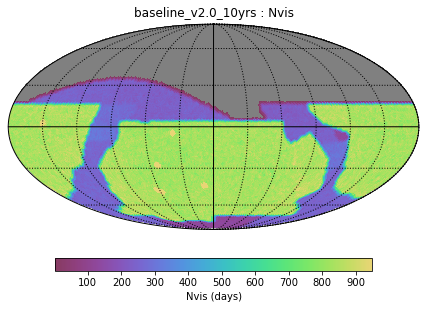

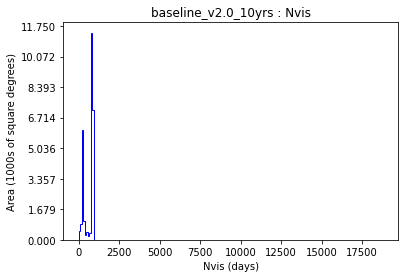

In [4]:
bundleDict = maf.metricBundles.makeBundlesDictFromList(bundleList)
bundleGroup = maf.MetricBundleGroup(bundleDict, opsim_db, outDir='test', resultsDb=None)
bundleGroup.runAll()
bundleGroup.plotAll(closefigs=False)

## Threshold in NVisits

What threshold should we apply to the total number of visits?  This depends on the science case, and we follow the approach of evaluating variability in categories defined by $\tau_{obs}$ (here converted to hours):

In [5]:
tau_obs = np.array([2.0, 20.0, 73.0, 365.0]) * 24.0

Assuming a simple, regular sampling of all HEALpix in the sky, the maximum possible number of visits to a HEALpix is a function of its annual visibility and survey cadence.  
Assuming a median seasonal visibility of 6 months, and an observing night lasting a fixed 8 hours / night, we can estimate the ideal number of visits as follows:

In [6]:
hours_in_obs_season = 6.0 * 30.0 * 24.0
hours_per_night = 8.0
n_visits_per_year = (hours_in_obs_season * hours_per_night) / tau_obs
n_visits_thresholds = n_visits_per_year * 10.0
n_visits_thresholds

array([7200.        ,  720.        ,  197.26027397,   39.45205479])

## Comparing Footprints



In [7]:
sampled_healpix = np.where(bundleDict['baseline_v2_0_10yrs_Nvis_HEAL'].metricValues >= n_visits_thresholds[1])[0]
unsampled_healpix = np.where(bundleDict['baseline_v2_0_10yrs_Nvis_HEAL'].metricValues < n_visits_thresholds[1])[0]
print('Pixels in well-sampled region: '+str(len(sampled_healpix)))
print('Pixels in poorly sampled region: '+str(len(unsampled_healpix)))
print('Total number of HEALpixels: '+str(len(bundleDict['baseline_v2_0_10yrs_Nvis_HEAL'].metricValues)))

Pixels in well-sampled region: 22324
Pixels in poorly sampled region: 26828
Total number of HEALpixels: 49152


0.0 180.0 -180.0 180.0


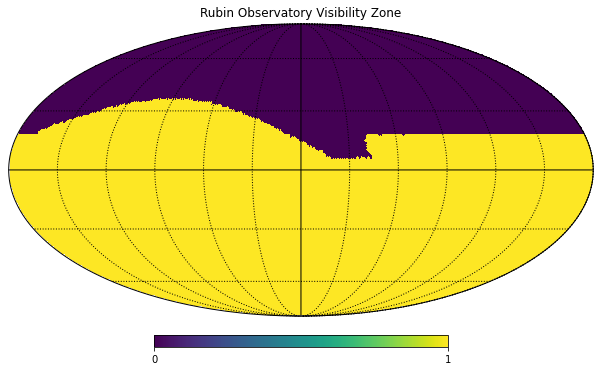

In [8]:
rubin_visibility_zone = np.where(bundleDict['baseline_v2_0_10yrs_Nvis_HEAL'].metricValues > 0)[0]
NPIX = hp.nside2npix(NSIDE)
map = np.zeros(NPIX)
map[rubin_visibility_zone] = 1.0
map_title = 'Rubin Observatory Visibility Zone'
hp.mollview(map, title=map_title)
hp.graticule()

In [9]:
print(sampled_healpix)

[18135 18136 18138 ... 48483 48484 48485]


In [10]:
def load_map_data(file_path):
    NSIDE = 64
    NPIX = hp.nside2npix(NSIDE)
    with fits.open(file_path) as hdul:
        map_data_table = hdul[1].data

    return map_data_table

In [11]:
map_file = os.path.join(get_data_dir(), 'maps', 'GalacticPlanePriorityMaps', 'priority_GalPlane_footprint_map_data_sum.fits')
map_data_table = load_map_data(map_file)
map_data = map_data_table['combined_map']

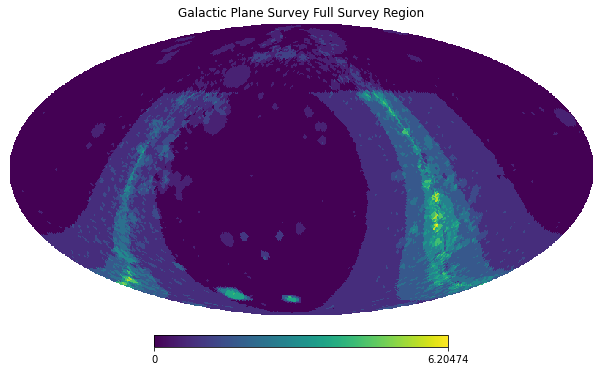

In [12]:
hp.mollview(map_data, title='Galactic Plane Survey Full Survey Region', min=0.0, max=map_data.max())

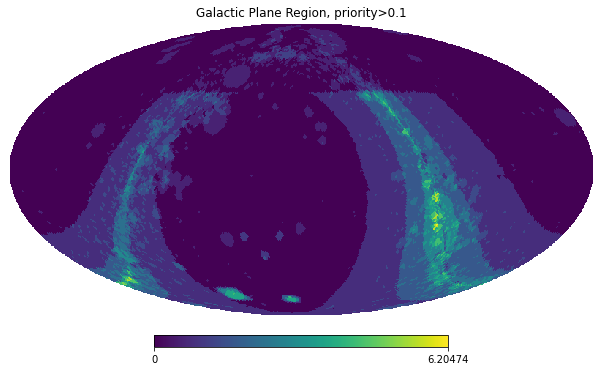

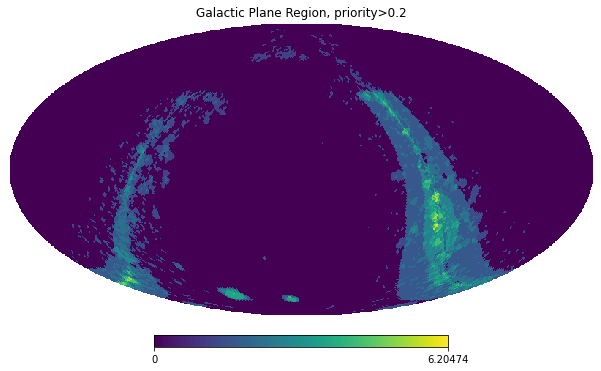

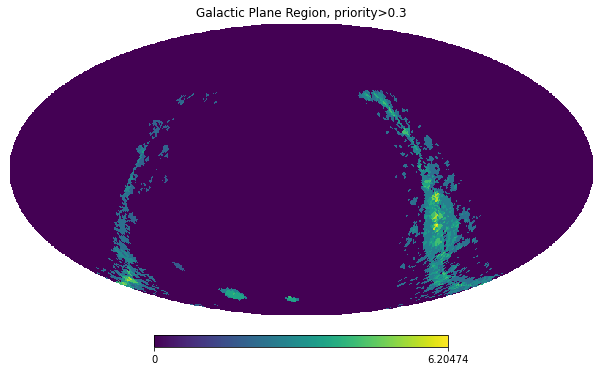

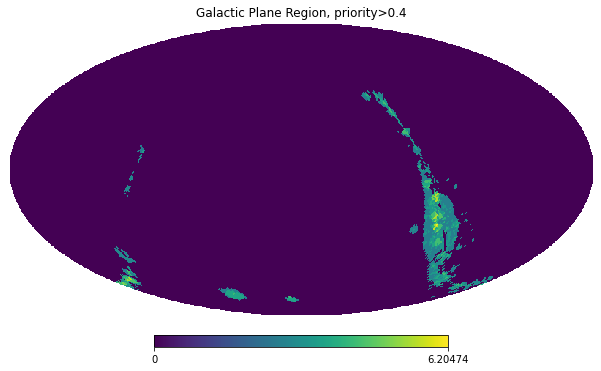

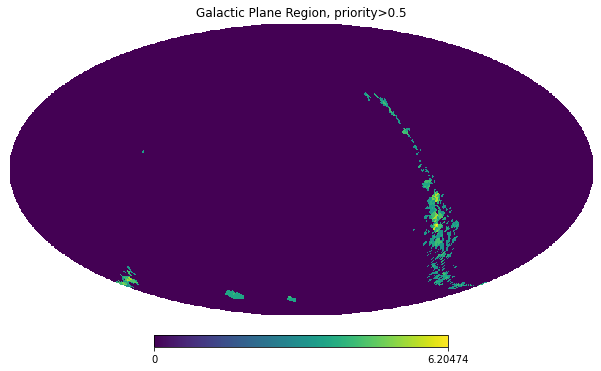

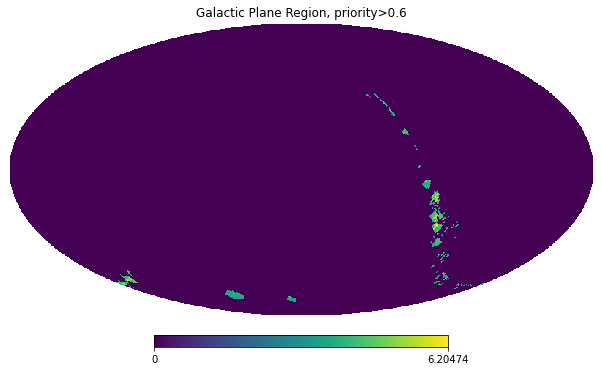

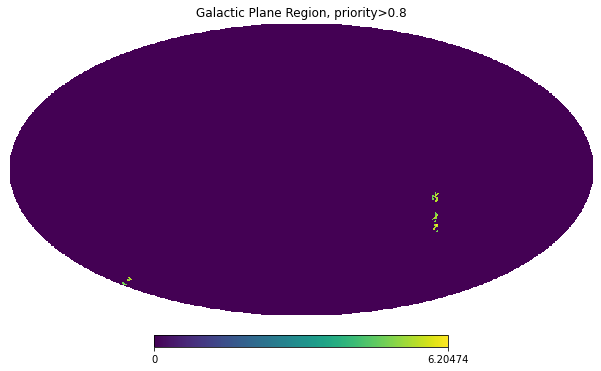

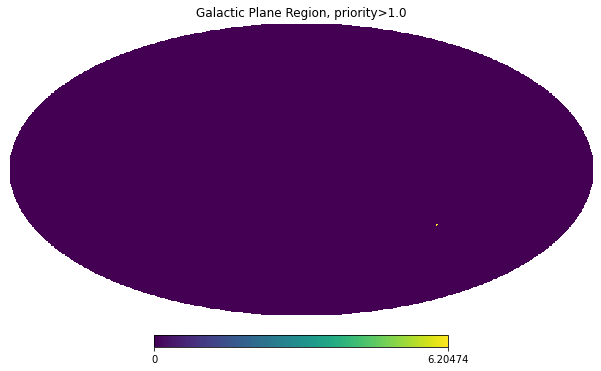

In [14]:
for priority in [0.1,0.2,0.3,0.4,0.5,0.6,0.8,1.0]:
    idx = np.where(map_data > priority*6) # Because we're using the sum map over all 6 filters
    sub_map_data = np.zeros(len(map_data))
    sub_map_data[idx] = map_data[idx]
    hp.mollview(sub_map_data, title='Galactic Plane Region, priority>'+str(priority), min=0.0, max=sub_map_data.max())

In [86]:
desired_healpix = np.where(map_data > 0.1)[0]

In [105]:
print(desired_healpix)

[   40    60    61 ... 49149 49150 49151]


Find the overlapping pixels between the ideal footprint in map_data and the sampled_healpix index

In [111]:
overlap_healpix = list(set(sampled_healpix).intersection(set(desired_healpix)))
missing_healpix = list(set(unsampled_healpix).intersection(set(desired_healpix)))

In [112]:
NPIX = hp.nside2npix(NSIDE)
map = np.zeros(NPIX)
map[overlap_healpix] = 1.0

0.0 180.0 -180.0 180.0


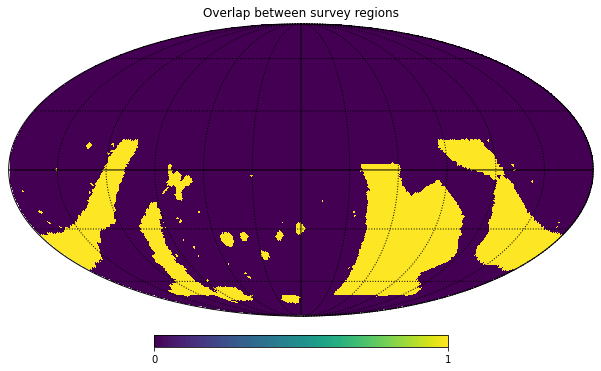

In [113]:
map_title = 'Overlap between survey regions'
hp.mollview(map, title=map_title)
hp.graticule()

In [110]:
l1 = [1,2,3,4,5]
l2 = [4,5,6,7,8]
l3 = set(l1).intersection(set(l2))
l3

{4, 5}

In [119]:
print(6*30)

180
